## Implicit Feedback Model

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

import cornac
from cornac.data import Reader
from cornac.eval_methods import BaseMethod, RatioSplit
from cornac.models import Recommender, BPR, WMF

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %tensorflow_version 1.x
import tensorflow as tf

print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 2020
VERBOSE = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cornac version: 1.7.1
Tensorflow version: 1.15.0


In [ ]:
df = pd.read_csv('data processing/filtered data/triplets_final.csv')
train_data = pd.read_csv('data processing/filtered data/triplets_final_train.csv')
test_data = pd.read_csv('data processing/filtered data/triplets_final_train.csv')

In [ ]:
eval_metrics = [
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=20),
  cornac.metrics.Recall(k=20),
  cornac.metrics.FMeasure(k=20),
  cornac.metrics.NDCG(k=[20]),
  cornac.metrics.NCRR(k=[20]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

In [ ]:
rs = RatioSplit(data=df.values, test_size=0.1, val_size=0.1, early_stop=True, verbose=True)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727354
Max rating = 150.0
Min rating = 2.0
Global mean = 4.9
---
Test data:
Number of users = 27977
Number of items = 11437
Number of ratings = 90913
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 28004
Number of items = 11445
Number of ratings = 90915
---
Total users = 29937
Total items = 12926


###  Define Additional Metrics

In [ ]:
song_play_num_users = df.groupby("song_id")["user_id"].nunique().sort_values(ascending=False)
song_play_num_users = pd.DataFrame(song_play_num_users).reset_index()
song_play_num_users.columns = ['song_id', 'popularity']
song_play_num_users = pd.merge(song_play_num_users, df[['song_id']].drop_duplicates(), on='song_id', how='left')

sum_pop = song_play_num_users['popularity'].sum()
song_play_num_users['popularity_ratio'] = song_play_num_users['popularity']/sum_pop

song_play_num_users['popularity_log'] = [math.log(1+ i) for i in song_play_num_users['popularity']]
                                                              
print(len(song_play_num_users))
song_play_num_users.head(10)

12934


,song_id,popularity,popularity_ratio,popularity_log
0,SONYKOW12AB01849C9,3892,0.004281,8.266935
1,SOPUCYA12A8C13A694,3436,0.003779,8.142354
2,SOCVTLJ12A6310F0FD,3393,0.003732,8.129764
3,SOKLRPJ12A8C13C3FE,3308,0.003638,8.104401
4,SOVDLZN12AB0185BEA,3018,0.003319,8.012681
5,SOLRGVL12A8C143BC3,2669,0.002936,7.889834
6,SOXWYZP12AF72A42A6,2567,0.002823,7.850883
7,SOUFPNI12A8C142D19,2486,0.002734,7.818832
8,SOXQYSC12A6310E908,2188,0.002407,7.691200
9,SOSCIZP12AB0181D2F,2159,0.002375,7.677864


In [ ]:
def get_rec_song_pop(rec_song_id):
    rec_song_pop = pd.merge(song_play_num_users, rec_song_id, on='song_id', how='inner')
    rec_song_pop = rec_song_pop.sort_values('popularity_ratio', ascending=False).reset_index().drop('index', axis=1)
    return rec_song_pop

def GiniIndex(rec_song_id):
    rec_song_pop = pd.merge(song_play_num_users[['song_id', 'popularity_ratio']], rec_song_id, on='song_id', how='inner')
    rec_song_pop = rec_song_pop.sort_values('popularity_ratio').reset_index()
    n = len(rec_song_pop)
    G = 0
    for j in range(n):
        G += (2*j-n-1) * rec_song_pop.popularity_ratio[j]
    return G/float(n-1)

def MeanPopularity(rec_song_id):
    rec_song_pop = pd.merge(song_play_num_users, rec_song_id, on='song_id', how='inner')
    return rec_song_pop.popularity_log.mean()   

In [ ]:
print('Original mean popularity of songs:', round(song_play_num_users.popularity.mean(), 2)) # how many users listened to a song
print('Original mean popularity degree of songs:',song_play_num_users.popularity_ratio.mean())

Original mean popularity of songs: 70.29
Original mean popularity degree of songs: 7.731560228854326e-05


In [ ]:
GiniIndex(song_play_num_users['song_id'])

0.6105281790017415

## 1. BPR

### 1.1. Base Model

In [ ]:
base_method = BaseMethod.from_splits(train_data.values, test_data.values, exclude_unknowns=True, seed=SEED, verbose=True)
bpr = BPR(k=20, max_iter=50, learning_rate=0.001, lambda_reg=0.001, verbose=False, seed=SEED, name=f"song_BPR")
cornac.Experiment(eval_method=base_method, models=[bpr], metrics=eval_metrics).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Max rating = 150.0
Min rating = 2.0
Global mean = 4.9
---
Test data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 29937
Total items = 12926

[song_BPR] Training started!

[song_BPR] Evaluation started!




TEST:
...
         |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
-------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
song_BPR | 0.8048 | 0.0586 | 0.0448 | 0.1994 |  0.0833 |  0.0746 |       0.0645 |    0.0561 |   11.0860 | 404.0004



### 1.2. Grid Search

In [ ]:
from cornac.hyperopt import Discrete, Continuous
from cornac.hyperopt import GridSearch, RandomSearch

bpr = BPR(max_iter=50, verbose=True, seed=2020)
auc = cornac.metrics.AUC()

In [ ]:
# Wrap BPR model inside GridSearch along with the searching space
gs_bpr = GridSearch(
    model=bpr,
    space=[
        Discrete("k", [20, 40, 60]),
        Discrete('learning_rate', [1e-4, 1e-3]), 
        Discrete("lambda_reg", [1e-2, 1e-3]),
    ],
    metric = auc,
    eval_method = rs,
)

# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=rs,
    models=[gs_bpr],
    metrics=eval_metrics,
    user_based=False,
).run()


[GridSearch_BPR] Training started!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.0001}



Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.001, 'learning_rate': 0.001}



Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.0001}



Optimization finished!
Evaluating: {'k': 20, 'lambda_reg': 0.01, 'learning_rate': 0.001}



Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.0001}



Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.001, 'learning_rate': 0.001}



Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.0001}



Optimization finished!
Evaluating: {'k': 40, 'lambda_reg': 0.01, 'learning_rate': 0.001}



Optimization finished!
Evaluating: {'k': 60, 'lambda_reg': 0.001, 'learning_rate': 0.0001}



Optimization finished!
Evaluating: {'k': 60, 'lambda_reg': 0.001, 'learning_rate': 0.001}



Optimization finished!
Evaluating: {'k': 60, 'lambda_reg': 0.01, 'learning_rate': 0.0001}



Optimization finished!
Evaluating: {'k': 60, 'lambda_reg': 0.01, 'learning_rate': 0.001}



Optimization finished!
Best parameter settings: {'k': 60, 'lambda_reg': 0.001, 'learning_rate': 0.001}
AUC = 0.7996

[GridSearch_BPR] Evaluation started!




VALIDATION:
...
               |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Time (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------
GridSearch_BPR | 0.7996 | 0.0144 | 0.0188 | 0.0414 |  0.0210 |  0.0307 |       0.0086 |    0.0565 | 210.5048

TEST:
...
               |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
GridSearch_BPR | 0.8015 | 0.0142 | 0.0188 | 0.0415 |  0.0210 |  0.0305 |       0.0085 |    0.0559 | 1251.0334 | 212.8186



### 1.3. Final BPR Model

In [ ]:
base_method = BaseMethod.from_splits(train_data.values, test_data.values, exclude_unknowns=True, seed=SEED, verbose=True)
bpr = BPR(k=60, max_iter=100, learning_rate=0.001, lambda_reg=0.001, verbose=False, seed=SEED, name=f"song_BPR")
cornac.Experiment(eval_method=base_method, models=[bpr], metrics=eval_metrics).run()

In [ ]:
base_method = BaseMethod.from_splits(train_data.values, test_data.values, exclude_unknowns=True, seed=SEED, verbose=True)
bpr = BPR(k=100, max_iter=100, learning_rate=0.001, lambda_reg=0.001, verbose=False, seed=SEED, name=f"song_BPR")
cornac.Experiment(eval_method=base_method, models=[bpr], metrics=eval_metrics).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Max rating = 150.0
Min rating = 2.0
Global mean = 4.9
---
Test data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 29937
Total items = 12926

[song_BPR] Training started!

[song_BPR] Evaluation started!




TEST:
...
         |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
-------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
song_BPR | 0.8048 | 0.0585 | 0.0447 | 0.2008 |  0.0833 |  0.0745 |       0.0644 |    0.0560 |   92.0808 | 716.0158



### 1.4. Save Model

In [ ]:
# Get items' latent vectors matrix
pd.DataFrame(bpr.i_factors).to_csv('Model/bpr_item_lf.csv', index=None)

In [ ]:
user_id2idx = bpr.train_set.uid_map
user_idx2id  = list(bpr.train_set.user_ids)
item_id2idx = bpr.train_set.iid_map
item_idx2id = list(bpr.train_set.item_ids)

In [ ]:
pd.DataFrame(user_idx2id).to_csv('Model/user_idx2id_bpr.csv', index=None)
pd.DataFrame(item_idx2id).to_csv('Model/item_idx2id_bpr.csv', index=None)

In [ ]:
uid = pd.DataFrame(list(user_id2idx), columns=['user_id'])

top20 = pd.DataFrame()
for u in uid.user_id:
    UIDX = uid[(uid['user_id']==u)].index[0]
    TOPK = 20

    recommendations, scores = bpr.rank(UIDX)

    rec_items = []
    for i in recommendations[:TOPK]:
        rec_items.append(item_idx2id[i])

    top20 = top20.append([rec_items])

print(top20.shape)

(29937, 20)


In [ ]:
top20['user_id'] = uid.user_id

In [ ]:
top20.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,user_id
0,SONYKOW12AB01849C9,SOKLRPJ12A8C13C3FE,SOPUCYA12A8C13A694,SOCVTLJ12A6310F0FD,SOVDLZN12AB0185BEA,SOXWYZP12AF72A42A6,SOUFPNI12A8C142D19,SOLRGVL12A8C143BC3,SOXQYSC12A6310E908,SOSCIZP12AB0181D2F,...,SOLWZVR12AB01849C6,SOSPXWA12AB0181875,SOVRTPN12AB0184F9E,SOKUTUM12A6701D9CD,SOXNZOW12AB017F756,SOJTLHS12A8C13F633,SOSVPIE12A6D4FA873,SOJSTYO12A8C13F200,SOEOJHS12AB017F3DC,6f10b752487dc65813e1ec34f78d4c89dbbb4890
0,SONYKOW12AB01849C9,SOKLRPJ12A8C13C3FE,SOPUCYA12A8C13A694,SOCVTLJ12A6310F0FD,SOVDLZN12AB0185BEA,SOXWYZP12AF72A42A6,SOUFPNI12A8C142D19,SOLRGVL12A8C143BC3,SOXQYSC12A6310E908,SOSCIZP12AB0181D2F,...,SOLWZVR12AB01849C6,SOSPXWA12AB0181875,SOVRTPN12AB0184F9E,SOKUTUM12A6701D9CD,SOXNZOW12AB017F756,SOJTLHS12A8C13F633,SOSVPIE12A6D4FA873,SOJSTYO12A8C13F200,SOEOJHS12AB017F3DC,6f10b752487dc65813e1ec34f78d4c89dbbb4890
0,SONYKOW12AB01849C9,SOKLRPJ12A8C13C3FE,SOPUCYA12A8C13A694,SOCVTLJ12A6310F0FD,SOVDLZN12AB0185BEA,SOXWYZP12AF72A42A6,SOUFPNI12A8C142D19,SOLRGVL12A8C143BC3,SOXQYSC12A6310E908,SOSCIZP12AB0181D2F,...,SOLWZVR12AB01849C6,SOSPXWA12AB0181875,SOVRTPN12AB0184F9E,SOKUTUM12A6701D9CD,SOXNZOW12AB017F756,SOJTLHS12A8C13F633,SOSVPIE12A6D4FA873,SOJSTYO12A8C13F200,SOEOJHS12AB017F3DC,6f10b752487dc65813e1ec34f78d4c89dbbb4890
0,SONYKOW12AB01849C9,SOPUCYA12A8C13A694,SOKLRPJ12A8C13C3FE,SOCVTLJ12A6310F0FD,SOVDLZN12AB0185BEA,SOXWYZP12AF72A42A6,SOUFPNI12A8C142D19,SOLRGVL12A8C143BC3,SOXQYSC12A6310E908,SOSCIZP12AB0181D2F,...,SOLWZVR12AB01849C6,SOSPXWA12AB0181875,SOVRTPN12AB0184F9E,SOKUTUM12A6701D9CD,SOXNZOW12AB017F756,SOJTLHS12A8C13F633,SOSVPIE12A6D4FA873,SOJSTYO12A8C13F200,SOEOJHS12AB017F3DC,6f10b752487dc65813e1ec34f78d4c89dbbb4890
0,SONYKOW12AB01849C9,SOKLRPJ12A8C13C3FE,SOPUCYA12A8C13A694,SOCVTLJ12A6310F0FD,SOVDLZN12AB0185BEA,SOXWYZP12AF72A42A6,SOUFPNI12A8C142D19,SOLRGVL12A8C143BC3,SOXQYSC12A6310E908,SOSCIZP12AB0181D2F,...,SOLWZVR12AB01849C6,SOSPXWA12AB0181875,SOVRTPN12AB0184F9E,SOKUTUM12A6701D9CD,SOXNZOW12AB017F756,SOJTLHS12A8C13F633,SOSVPIE12A6D4FA873,SOJSTYO12A8C13F200,SOEOJHS12AB017F3DC,6f10b752487dc65813e1ec34f78d4c89dbbb4890


In [ ]:
top20.to_csv('Model/top20_bpr.csv', index=None)

In [ ]:
bpr.save('Model/')

'Model/song_BPR\\2020-07-26_15-36-55-116245.pkl'

In [ ]:
import pickle

# save the model to disk
filename = 'finalized_bpr_model'
pickle.dump(bpr, open(filename, 'wb'))

# # # load the model from disk
# # loaded_model = pickle.load(open('finalized_bpr_model', 'rb'))

### 1.5.  BPR additional metrics

In [ ]:
top20 = pd.read_csv('Model/top20_bpr.csv')

In [ ]:
df1 = top20[[0]]
df1.columns=['song_id']
df2 = top20[[1]]
df2.columns=['song_id']
rec_song_df = pd.concat([df1, df2])
for i in range(2, 20):
    df_i = top20[[i]]
    df_i.columns=['song_id']
    rec_song_df = pd.concat([rec_song_df, df_i])
    
print(rec_song_df.shape)

(598740, 1)


In [ ]:
rec_song_id = rec_song_df.drop_duplicates()
rec_song_pop = get_rec_song_pop(rec_song_id)
print(len(rec_song_pop))
print('Mean popularity of songs:', round(rec_song_pop.popularity.mean(), 2)) # how many users listened to a song
print('Mean popularity degree of songs:',MeanPopularity(rec_song_id))

20
Original mean popularity of songs: 2407.8
Original mean popularity degree of songs: 7.753515270840415


In [ ]:
rec_song_id = rec_song_df.drop_duplicates()
print('GiniIndex:', GiniIndex(rec_song_id))

GiniIndex: 0.002598021173872571


In [ ]:
rec_song_id = rec_song_df.drop_duplicates()
rec_song_pop = get_rec_song_pop(rec_song_id)
print(len(rec_song_pop))
print('Mean popularity of songs:', round(rec_song_pop.popularity.mean(), 2)) # how many users listened to a song
print('Mean popularity degree of songs:',MeanPopularity(rec_song_id))

20
Original mean popularity of songs: 2411.0
Original mean popularity degree of songs: 0.0026517992859609713


In [ ]:
rec_song_id = rec_song_df.drop_duplicates()
print('GiniIndex:', GiniIndex(rec_song_id))

GiniIndex: 0.0025202194702699677


### 1.6.  Visulize BPR Recommendation

In [ ]:
rec_song_frequence = rec_song_df.reset_index().groupby('song_id').count().reset_index()
rec_song_frequence.columns = ['song_id', 'frequence']
plot1 = pd.merge(song_play_num_users, rec_song_frequence, on='song_id', how='inner').sort_values('popularity', ascending=False)

In [ ]:
plot1.head(5)

,song_id,popularity,popularity_ratio,popularity_log,frequence
0,SONYKOW12AB01849C9,3892,0.004281,8.266935,5873
1,SOPUCYA12A8C13A694,3436,0.003779,8.142354,1968
2,SOCVTLJ12A6310F0FD,3393,0.003732,8.129764,4284
3,SOKLRPJ12A8C13C3FE,3308,0.003638,8.104401,5377
4,SOVDLZN12AB0185BEA,3018,0.003319,8.012681,1297


[Text(0, 0.5, 'recommendation frequnce'),
 Text(0.5, 0, 'item ordered by decreasing popularity'),
 Text(0.5, 1.0, 'Recommendation frequence by song popularity')]

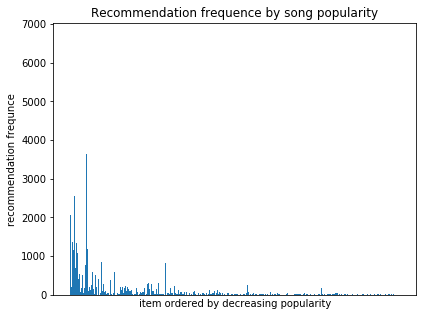

In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 5))

ax.bar(x = plot1.popularity.index, height = plot1.frequence, width=1.0, align="edge")
ax.set_xticks([])
ax.set(title="Recommendation frequence by song popularity", 
            xlabel="item ordered by decreasing popularity", 
            ylabel="recommendation frequnce")
# ax.set_ylim([0, 6000])

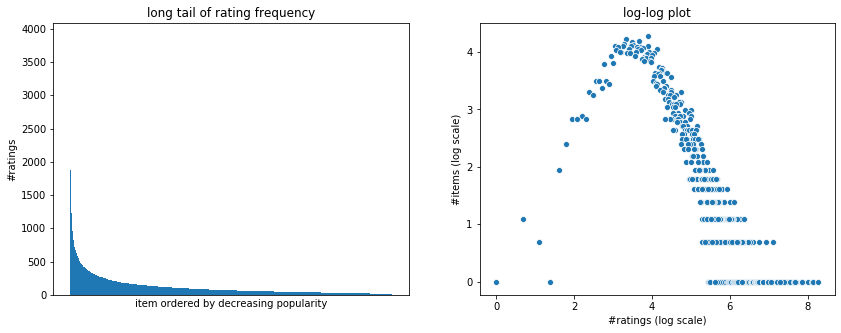

In [ ]:
sample_df = plot1.popularity
sample_df = sample_df.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=sample_df.index, height=sample_df.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing popularity", 
            ylabel="#ratings")
# axes[0].set_ylim([0, 5000])

count = sample_df.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

In [ ]:
song_sum_play_count = df[['song_id', 'play_count']].groupby('song_id').sum()
song_sum_play_count = song_sum_play_count.reset_index()
song_sum_play_count.columns = ['song_id', 'sum_play_count']

In [ ]:
plot2 = pd.merge(plot1, song_sum_play_count, on='song_id', how='inner')
plot2.head(5)

,song_id,popularity,popularity_ratio,frequence,sum_play_count
0,SONYKOW12AB01849C9,3892,0.004281,29937,26008
1,SOPUCYA12A8C13A694,3436,0.003779,29937,37465
2,SOCVTLJ12A6310F0FD,3393,0.003732,29937,16109
3,SOKLRPJ12A8C13C3FE,3308,0.003638,29937,16120
4,SOVDLZN12AB0185BEA,3018,0.003319,29937,16626


### 2. WMF

### 2.1. Base Model

In [ ]:
base_method = BaseMethod.from_splits(train_data.values, test_data.values, exclude_unknowns=True, seed=SEED, verbose=True)
wmf = WMF(k=20, max_iter=50, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.001, lambda_v=0.001,
          verbose=False, seed=SEED, name=f"song_WMF")

cornac.Experiment(eval_method=base_method, models=[wmf], metrics=eval_metrics).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Max rating = 150.0
Min rating = 2.0
Global mean = 4.9
---
Test data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 29937
Total items = 12926

[song_WMF] Training started!

[song_WMF] Evaluation started!




TEST:
...
         |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
-------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
song_WMF | 0.9356 | 0.1871 | 0.1565 | 0.4802 |  0.2661 |  0.2377 |       0.2040 |    0.1805 | 1037.7862 | 407.0961



### 2.2. Grid Search

In [ ]:
from cornac.hyperopt import Discrete, Continuous
from cornac.hyperopt import GridSearch, RandomSearch

wmf = WMF(a=1.0, lambda_u=0.001, lambda_v=0.001, max_iter=50, verbose=True, seed=2020)
auc = cornac.metrics.AUC()

In [ ]:
# Wrap WMF model inside GridSearch along with the searching space
gs_wmf = GridSearch(
    model=wmf,
    space=[
        Discrete("k", [20, 40, 60]),
        Discrete('learning_rate', [1e-4, 1e-3]), 
        Discrete("b", [1e-2, 1e-3]),
    ],
    metric=auc,
    eval_method = rs,
)

# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=rs,
    models=[gs_wmf],
    metrics=eval_metrics,
    user_based=False
).run()


[GridSearch_WMF] Training started!
Evaluating: {'b': 0.001, 'k': 20, 'learning_rate': 0.0001}



Learning completed!
Evaluating: {'b': 0.001, 'k': 20, 'learning_rate': 0.001}



Learning completed!
Evaluating: {'b': 0.001, 'k': 40, 'learning_rate': 0.0001}



Learning completed!
Evaluating: {'b': 0.001, 'k': 40, 'learning_rate': 0.001}



Learning completed!
Evaluating: {'b': 0.001, 'k': 60, 'learning_rate': 0.0001}



Learning completed!
Evaluating: {'b': 0.001, 'k': 60, 'learning_rate': 0.001}



Learning completed!
Evaluating: {'b': 0.01, 'k': 20, 'learning_rate': 0.0001}



Learning completed!
Evaluating: {'b': 0.01, 'k': 20, 'learning_rate': 0.001}



Learning completed!
Evaluating: {'b': 0.01, 'k': 40, 'learning_rate': 0.0001}



Learning completed!
Evaluating: {'b': 0.01, 'k': 40, 'learning_rate': 0.001}



Learning completed!
Evaluating: {'b': 0.01, 'k': 60, 'learning_rate': 0.0001}



Learning completed!
Evaluating: {'b': 0.01, 'k': 60, 'learning_rate': 0.001}



Learning completed!
Best parameter settings: {'b': 0.01, 'k': 40, 'learning_rate': 0.001}
AUC = 0.9004

[GridSearch_WMF] Evaluation started!




VALIDATION:
...
               |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Time (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------
GridSearch_WMF | 0.9004 | 0.0430 | 0.0488 | 0.0957 |  0.0546 |  0.0858 |       0.0258 |    0.1676 | 275.0002

TEST:
...
               |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 |  Train (s) | Test (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + ---------- + --------
GridSearch_WMF | 0.9014 | 0.0428 | 0.0499 | 0.0971 |  0.0557 |  0.0868 |       0.0257 |    0.1681 | 15503.5628 | 265.1237



### 2.3. Final WMF Model

In [ ]:
base_method = BaseMethod.from_splits(train_data.values, test_data.values, exclude_unknowns=True, seed=SEED, verbose=True)
wmf = WMF(k=40, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.001, lambda_v=0.001,
          verbose=False, seed=SEED, name=f"song_WMF")

cornac.Experiment(eval_method=base_method, models=[wmf], metrics=eval_metrics).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Max rating = 150.0
Min rating = 2.0
Global mean = 4.9
---
Test data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 29937
Total items = 12926

[song_WMF] Training started!

[song_WMF] Evaluation started!




TEST:
...
         |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
-------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
song_WMF | 0.9627 | 0.2352 | 0.2114 | 0.7148 |  0.3871 |  0.3206 |       0.2551 |    0.2278 | 2342.8534 | 495.0885



### 2.4. Save Model

In [ ]:
# Get items' latent vectors matrix
pd.DataFrame(wmf.V).to_csv('Model/wmf_item_lf.csv', index=None)

In [ ]:
user_id2idx = wmf.train_set.uid_map
user_idx2id  = list(wmf.train_set.user_ids)
item_id2idx = wmf.train_set.iid_map
item_idx2id = list(wmf.train_set.item_ids)

In [ ]:
pd.DataFrame(user_idx2id).to_csv('Model/user_idx2id_wmf.csv', index=None)
pd.DataFrame(item_idx2id).to_csv('Model/item_idx2id_wmf.csv', index=None)

In [ ]:
uid = pd.DataFrame(list(user_id2idx), columns=['user_id'])

top20 = pd.DataFrame()
for u in uid.user_id:
    UIDX = uid[(uid['user_id']==u)].index[0]
    TOPK = 20

    recommendations, scores = wmf.rank(UIDX)

    rec_items = []
    for i in recommendations[:TOPK]:
        rec_items.append(item_idx2id[i])

    top20 = top20.append([rec_items])

In [ ]:
top20['user_id'] = uid.user_id

In [ ]:
top20.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,user_id
0,SOVMOCU12A8C140E82,SOAETMP12A8C140E7F,SOSFFQC12A6D4F8885,SOBDEWX12AB018026E,SOUVGJL12AB017FC35,SOYDTIW12A67ADAFC9,SOWIYOP12A8C140E73,SOOXJDU12A8AE47ECB,SOBYSRH12A8C13AE98,SOFOWTV12AB017E7B7,...,SOYLUOK12AF72AA67F,SOGISVQ12A8C13AE9B,SOSJIUS12A8C13C501,SOCBBGJ12AF72A0922,SOTSRUQ12A81C22359,SOSNVLO12A8C13C524,SOUEGBF12AB017EFD5,SONBNVV12A8151B825,SODUANR12A6D4F5036,6f10b752487dc65813e1ec34f78d4c89dbbb4890
0,SOTOXBH12AAF3B5B96,SOQJLTG12AAA8C665D,SOQHFWA12AAA8C6662,SOVQLNZ12AC4687BAA,SOZXBVL12AB0184D35,SOTMYHL12AAA8C666E,SOKTJKI12A8C143254,SOLQEKT12AB0184E57,SOTHGKN12AAA8C6637,SOMGEWY12A6D4FC220,...,SODADBO12AB0186903,SOHVDZM12A8C13AE07,SOAJDBZ12A6D4FA3C8,SOPZBVQ12AF72A21E6,SOPFRIW12A8C13BBC0,SOFRZZT12A8C1351E6,SOQENWM12AB017EDE0,SOBEVGM12A67ADBCA7,SOFGCLQ12A8C1410D2,6f10b752487dc65813e1ec34f78d4c89dbbb4890
0,SOYDTIW12A67ADAFC9,SOVMOCU12A8C140E82,SOAETMP12A8C140E7F,SOSFFQC12A6D4F8885,SODRVBA12A58A7F235,SOWIYOP12A8C140E73,SOSNYHM12A67ADAFC8,SOOXJDU12A8AE47ECB,SOQZKFH12AC90719F4,SOYITRT12A6D4FA789,...,SOTGZIH12A8C1428A5,SOXVTXV12AB018B33E,SOGISVQ12A8C13AE9B,SOEGVNQ12AC95F05B9,SOTVDOJ12AB017DB80,SODUANR12A6D4F5036,SOQFCSW12A8C134586,SOOQCAG12A67ADE6DD,SORFVMQ12AB0184135,6f10b752487dc65813e1ec34f78d4c89dbbb4890
0,SOXWYZP12AF72A42A6,SOILFUU12AB017C75F,SOXQXXU12A67021CC3,SOVITPC12AC468A1B7,SOUCPBK12A58A7881A,SOXNZOW12AB017F756,SOODSPH12AB01819C3,SOMOKCH12A8159E8A0,SOUFPNI12A8C142D19,SOWLFNL12AB017DB20,...,SOVDLZN12AB0185BEA,SOVJHCB12A8AE4636E,SOSUWJE12AB0184567,SOUYQOB12AC468A1F3,SOQEROB12A8C13DF51,SOVRTPN12AB0184F9E,SOQIOXQ12AAF3B2A37,SODPPDY12AB017F767,SOPVDJB12AC468B28B,6f10b752487dc65813e1ec34f78d4c89dbbb4890
0,SOAAFAC12A67ADF7EB,SOOCEKO12A67ADF6D9,SOGEMSR12AB01854A3,SOXONZC12A67ADF6DA,SORVKCB12AB0188D90,SOFZOTX12A67ADF6DB,SODLCIU12A8AE45F1D,SOKEUYU12A67ADF7E6,SOMSEAO12A67ADF6BE,SOFGANQ12A67ADF6BD,...,SOCLEPJ12AB01838DA,SOATQYE12A6D4F8167,SOBGPEH12A6D4F818B,SOCBIFT12A8C13E7C3,SOOYYKJ12A8C13CDDC,SOYQQAG12A58A7D541,SOKSPLY12AB018452F,SOOZQNS12A8C13B646,SOHSXAV12A67ADF7E7,6f10b752487dc65813e1ec34f78d4c89dbbb4890


In [ ]:
top20.to_csv('Model/top20_wmf.csv', index=None)

In [ ]:
wmf.save('Model/')

'Model/song_WMF\\2020-07-26_22-00-00-542749.pkl'

In [ ]:
import pickle

# save the model to disk
filename = 'finalized_wmf_model'
pickle.dump(wmf, open(filename, 'wb'))

# # # load the model from disk
# # loaded_model = pickle.load(open('finalized_wmf_model', 'rb'))

### 2.5.  WMF additional metrics

In [ ]:
top20 = pd.read_csv('Model/top20_wmf3.csv')

In [ ]:
df1 = top20[[str(0)]]
df1.columns=['song_id']
df2 = top20[[str(1)]]
df2.columns=['song_id']
rec_song_df = pd.concat([df1, df2])
for i in range(2, 20):
    df_i = top20[[str(i)]]
    df_i.columns=['song_id']
    rec_song_df = pd.concat([rec_song_df, df_i])
    
print(rec_song_df.shape)

(598740, 1)


In [ ]:
rec_song_id = rec_song_df.drop_duplicates()
rec_song_pop = get_rec_song_pop(rec_song_id)
print(len(rec_song_pop))
print('Mean popularity of recommended songs:', round(rec_song_pop.popularity.mean(), 2)) # how many users listened to a song
print('Mean popularity degree of recommended songs:',MeanPopularity(rec_song_id))

5735
Mean popularity of recommended songs: 124.41
Mean popularity degree of recommended songs: 4.303890732055588


In [ ]:
rec_song_id = rec_song_df.drop_duplicates()
print('GiniIndex:', GiniIndex(rec_song_id))

GiniIndex: 0.43146164479918314


### 2.6.  Visulize WMF Recommendation

In [ ]:
rec_song_frequence = rec_song_df.reset_index().groupby('song_id').count().reset_index()
rec_song_frequence.columns = ['song_id', 'frequence']
plot1 = pd.merge(song_play_num_users, rec_song_frequence, on='song_id', how='inner').sort_values('popularity', ascending=False)

In [ ]:
song_sum_play_count = df[['song_id', 'play_count']].groupby('song_id').sum()
song_sum_play_count = song_sum_play_count.reset_index()
song_sum_play_count.columns = ['song_id', 'sum_play_count']

In [ ]:
plot2 = pd.merge(plot1, song_sum_play_count, on='song_id', how='inner')
plot2.head(5)

,song_id,popularity,popularity_ratio,popularity_log,frequence,sum_play_count
0,SONYKOW12AB01849C9,3892,0.004281,8.266935,5873,26008
1,SOPUCYA12A8C13A694,3436,0.003779,8.142354,1968,37465
2,SOCVTLJ12A6310F0FD,3393,0.003732,8.129764,4284,16109
3,SOKLRPJ12A8C13C3FE,3308,0.003638,8.104401,5377,16120
4,SOVDLZN12AB0185BEA,3018,0.003319,8.012681,1297,16626


(0, 2500)

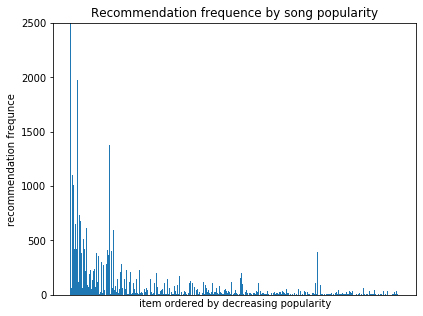

In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 5))

ax.bar(x = plot1.popularity.index, height = plot1.frequence, width=1.0, align="edge")
ax.set_xticks([])
ax.set(title="Recommendation frequence by song popularity", 
            xlabel="item ordered by decreasing popularity", 
            ylabel="recommendation frequnce")
ax.set_ylim([0, 2500])

(0, 20000)

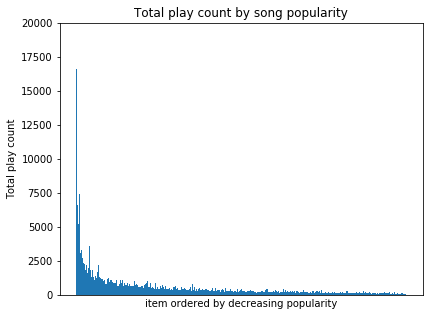

In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 5))

ax.bar(x = plot2.popularity.index, height = plot2.sum_play_count, width=1.0, align="edge")
ax.set_xticks([])
ax.set(title="Total play count by song popularity", 
            xlabel="item ordered by decreasing popularity", 
            ylabel="Total play count")
ax.set_ylim([0, 20000])

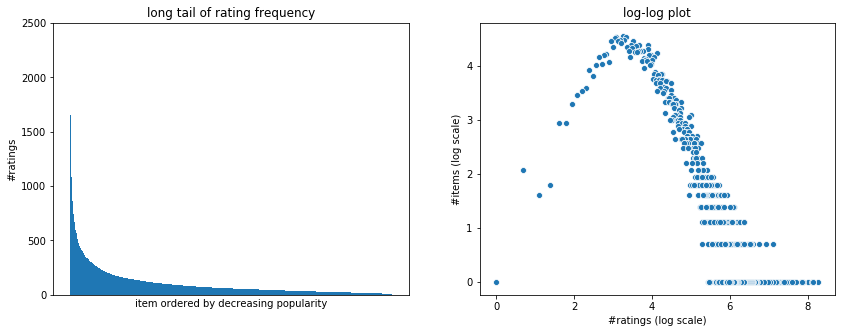

In [ ]:
sample_df = plot1.popularity
sample_df = sample_df.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=sample_df.index, height=sample_df.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing popularity", 
            ylabel="#ratings")
axes[0].set_ylim([0, 2500])

count = sample_df.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

### 2.7. Interpreting Recommendations of WMF

Let's pick a user and see what the top-K recommendations by WMF model are.  

In [ ]:
metadata = pd.read_csv('data processing/filtered data/metadata.csv')

In [ ]:
user_df = metadata[['user_id', 'song_id', 'title', 'artist_name', 'genre', 'year', 'play_count']]
song_df = metadata[['song_id', 'title', 'artist_name', 'genre', 'year']].drop_duplicates()

In [ ]:
UIDX = 0
user_df[user_df['user_id'] == user_idx2id[UIDX]].sort_values('play_count', ascending=False).iloc[:, 1:].reset_index().drop('index', axis=1)

,song_id,title,artist_name,genre,year,play_count
0,SOWSPUS12AC468BEE3,Bigger Isn't Better,The String Cheese Incident,Country_Traditional,1997,67
1,SOLGJNB12A8C13473D,Equilibrium,Satchel,Rock_Alternative,1994,17
2,SOUVGJL12AB017FC35,Our Song,Taylor Swift,Country_Traditional,2006,11
3,SOBYSRH12A8C13AE98,Heavy Water,Foals,Pop_Indie,2008,8
4,SONAZWN12A8151C957,White Winter Hymnal,Fleet Foxes,Rock_Alternative,2008,5
5,SOWVBDQ12A8C13503D,Volveré,Gian Marco,Pop_Latin,0,4
6,SOGISVQ12A8C13AE9B,Big Big Love (Fig .2),Foals,Pop_Indie,2008,4
7,SOUINTM12AB01840DF,Wrecking Ball,Mother Mother,Pop_Indie,2008,4
8,SOAJBCA12AB0186BFE,Body,Mother Mother,Pop_Indie,2008,3
9,SOJFMFG12AB0186BE0,O My Heart,Mother Mother,Pop_Indie,2008,3


In [ ]:
UIDX = 0
TOPK = 20

item_id2idx = wmf.train_set.iid_map
item_idx2id = list(wmf.train_set.item_ids)

recommendations, scores = wmf.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS:")
print("Scores:", scores[recommendations[:TOPK]])
rec_songid = pd.DataFrame([item_idx2id[i] for i in recommendations[:TOPK]])
rec_songid.columns = ['song_id']
pd.merge(song_df, rec_songid, on='song_id', how='inner')


TOP 20 RECOMMENDATIONS:
Scores: [4.5902905 4.3384695 4.3241835 4.2486405 4.2135673 4.1635094 4.062596
 3.9914713 3.9896898 3.917434  3.8203206 3.804694  3.7482982 3.7344499
 3.6474428 3.6422217 3.6066265 3.6060278 3.564055  3.5244012]


,song_id,title,artist_name,genre,year
0,SOTSRUQ12A81C22359,Nantes,Beirut,Pop_Indie,2007
1,SOVMOCU12A8C140E82,Mutiny_ I Promise You,The New Pornographers,Rock_College,2007
2,SOWIYOP12A8C140E73,Entering White Cecilia,The New Pornographers,Rock_College,2007
3,SOUKPBU12A8C140E2E,Challengers,The New Pornographers,Rock_College,2007
4,SOAETMP12A8C140E7F,Go Places,The New Pornographers,Rock_College,2007
5,SOOXJDU12A8AE47ECB,Again & Again,the bird and the bee,Pop_Indie,2006
6,SOSJIUS12A8C13C501,The Bleeding Heart Show,The New Pornographers,Punk,2005
7,SOYDTIW12A67ADAFC9,The Police And The Private,Metric,Pop_Indie,2005
8,SOCBBGJ12AF72A0922,Sleeping Sickness,City And Colour,Rock_Contemporary,2008
9,SOYLUOK12AF72AA67F,This Charming Man,Stars,Pop_Indie,2000


### 2.8. WMF Latent Factors

Below is the variance of each latent dimension across different items.  If a factor or dimension has higher variance, it is better at discriminating among different items.  Conversely, if the variance of a factor is too small, it implies that most items would have a similar value for that factor.

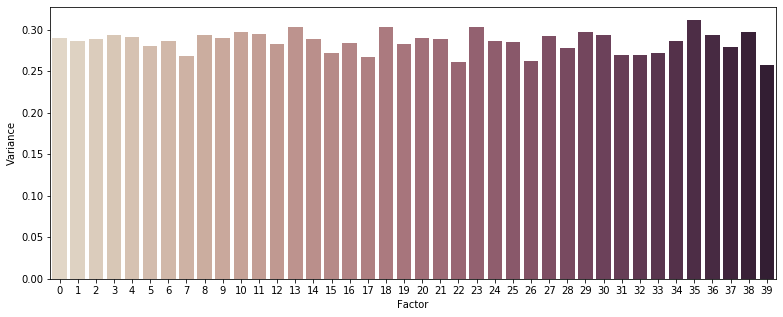

In [ ]:
K = 40
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(wmf.V, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

### 2.9. Impact of the number of latent factors - K 

In [ ]:
base_method = BaseMethod.from_splits(train_data.values, test_data.values, exclude_unknowns=True, seed=SEED, verbose=True)

wmf1 = WMF(k=5, max_iter=50, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.001, lambda_v=0.001,
          verbose=True, seed=SEED, name="song_WMF{K=5}")
wmf2 = WMF(k=10, max_iter=50, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.001, lambda_v=0.001,
          verbose=False, seed=SEED, name="song_WMF{K=10}")
wmf3 = WMF(k=20, max_iter=50, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.001, lambda_v=0.001,
          verbose=False, seed=SEED, name="song_WMF{K=20}")
wmf4 = WMF(k=30, max_iter=50, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.001, lambda_v=0.001,
          verbose=False, seed=SEED, name="song_WMF{K=30}")

cornac.Experiment(eval_method=base_method, models=[wmf1, wmf2, wmf3, wmf4], metrics=eval_metrics).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Max rating = 150.0
Min rating = 2.0
Global mean = 4.9
---
Test data:
Number of users = 29937
Number of items = 12926
Number of ratings = 727355
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 29937
Total items = 12926

[song_WMF{K=5}] Training started!



Learning completed!

[song_WMF{K=5}] Evaluation started!




[song_WMF{K=10}] Training started!

[song_WMF{K=10}] Evaluation started!




[song_WMF{K=20}] Training started!

[song_WMF{K=20}] Evaluation started!




[song_WMF{K=30}] Training started!

[song_WMF{K=30}] Evaluation started!




TEST:
...
               |    AUC |  F1@20 |    MAP |    MRR | NCRR@20 | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
-------------- + ------ + ------ + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
song_WMF{K=5}  | 0.8702 | 0.0348 | 0.0358 | 0.1074 |  0.0390 |  0.0400 |       0.0391 |    0.0330 | 1063.2702 | 405.4698
song_WMF{K=10} | 0.9068 | 0.1204 | 0.0980 | 0.2769 |  0.1481 |  0.1429 |       0.1317 |    0.1158 | 1059.5511 | 378.4906
song_WMF{K=20} | 0.9356 | 0.1871 | 0.1565 | 0.4802 |  0.2661 |  0.2377 |       0.2040 |    0.1805 | 1038.5253 | 390.4194
song_WMF{K=30} | 0.9493 | 0.2211 | 0.1904 | 0.6028 |  0.3347 |  0.2894 |       0.2408 |    0.2135 | 1064.4046 | 386.2026



In [ ]:
import pickle

# save the model to disk
filename = 'finalized_wmf4_model'
pickle.dump(wmf4, open(filename, 'wb'))

# # # load the model from disk
# # loaded_model = pickle.load(open('finalized_wmf_model', 'rb'))

In [ ]:
user_id2idx = wmf4.train_set.uid_map
user_idx2id  = list(wmf4.train_set.user_ids)
item_id2idx = wmf4.train_set.iid_map
item_idx2id = list(wmf4.train_set.item_ids)

uid = pd.DataFrame(list(user_id2idx), columns=['user_id'])

top20 = pd.DataFrame()
for u in uid.user_id:
    UIDX = uid[(uid['user_id']==u)].index[0]
    TOPK = 20

    recommendations, scores = wmf4.rank(UIDX)

    rec_items = []
    for i in recommendations[:TOPK]:
        rec_items.append(item_idx2id[i])

    top20 = top20.append([rec_items])

In [ ]:
top20.to_csv('Model/top20_wmf4.csv', index=None)

In [ ]:
df1 = top20[[0]]
df1.columns=['song_id']
df2 = top20[[1]]
df2.columns=['song_id']
rec_song_df = pd.concat([df1, df2])
for i in range(2, 20):
    df_i = top20[[i]]
    df_i.columns=['song_id']
    rec_song_df = pd.concat([rec_song_df, df_i])
    
print(rec_song_df.shape)

(598740, 1)


In [ ]:
rec_song_id = rec_song_df.drop_duplicates()
rec_song_pop = get_rec_song_pop(rec_song_id)
print(len(rec_song_pop))
print('Mean popularity of recommended songs:', round(rec_song_pop.popularity.mean(), 2)) # how many users listened to a song
print('Mean popularity degree of recommended songs:',MeanPopularity(rec_song_id))

7005
Mean popularity of recommended songs: 109.63
Mean popularity degree of recommended songs: 4.159665393663071


In [ ]:
rec_song_id = rec_song_df.drop_duplicates()
print('GiniIndex:', GiniIndex(rec_song_id))

GiniIndex: 0.47298709184745064
